In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting.metrics import MAE, RMSE

In [3]:
import pandas as pd

In [4]:
from pytorch_forecasting.data import examples
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder

In [5]:
import torch

## Random data

In [28]:
data = examples.generate_ar_data(seasonality=10.0, timesteps=400, n_series=100)
data["static"] = "2"
data

,series,time_idx,value,static
0,0,0,-0.000000,2
1,0,1,0.033712,2
2,0,2,0.061853,2
3,0,3,0.099868,2
4,0,4,0.139527,2
...,...,...,...,...
39995,99,395,-3.131300,2
39996,99,396,-2.617983,2
39997,99,397,-2.127988,2
39998,99,398,-2.714650,2


In [29]:
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,0.033712,2,2020-01-02
2,0,2,0.061853,2,2020-01-03
3,0,3,0.099868,2,2020-01-04
4,0,4,0.139527,2,2020-01-05
...,...,...,...,...,...
39995,99,395,-3.131300,2,2021-01-30
39996,99,396,-2.617983,2,2021-01-31
39997,99,397,-2.127988,2,2021-02-01
39998,99,398,-2.714650,2,2021-02-02


In [31]:
validation = data.series.sample(20)
validation

20029    50
5329     13
14861    37
6638     16
1268      3
22291    55
9967     24
21256    53
37977    94
22774    56
701       1
13077    32
14935    37
12749    31
4072     10
25173    62
19058    47
17472    43
34189    85
32283    80
Name: series, dtype: int64

In [33]:
training = TimeSeriesDataSet(
    data[lambda x: ~x.series.isin(validation)],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=["static"],
    min_encoder_length=60,
    max_encoder_length=60,
    min_prediction_length=20,
    max_prediction_length=20,
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["series"]),
    add_relative_time_idx=False,
    add_target_scales=True,
    randomize_length=None,
)

In [34]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    data[lambda x: x.series.isin(validation)],
    # predict=True,
    stop_randomization=True,
)

In [35]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

In [51]:
train = torch.cat([y for x, (y, weight) in iter(train_dataloader)])
train.shape

torch.Size([25984, 20])

In [36]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [37]:
trainer = pl.Trainer(
    max_epochs=50,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
)


deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [40]:
torch.set_num_threads(10)
trainer.fit(
    deepar,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 1     
3 | rnn                    | LSTM                   | 13.4 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\dmoho\Documents\FRI\4_letnik_1_semester\SU\Projekt\pytorch-forecasting\pytorch_forecasting\data\timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [43]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
predictions = deepar.predict(val_dataloader)

torch.Size([6099, 20])

In [50]:
print(f"Mean absolute error of model: {(actuals - predictions).abs().mean()}")

Mean absolute error of model: 1.910607099533081


# My data

In [138]:
data = pd.read_csv("./ETT-data/ETTh1.csv", sep=",")
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [139]:
data["time_idx"] = [x for x in range(data.shape[0])]
data["group"] = 0
data["date"] = data["date"].apply(lambda x: pd.to_datetime(x))
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,time_idx,group
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0,0
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1,0
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2,0
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,3,0
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,4,0
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,17415,0
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,17416,0
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,17417,0
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,17418,0


In [140]:
# Standardize
numerical = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
column_std = dict()
for num in numerical:
    x = data[num]
    avg = x.mean()
    std = x.std()
    column_std[num] = {"mean": avg, "std": std}
    data[num] = (data[num]-avg)/std

In [142]:
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,time_idx,group
0,2016-07-01 00:00:00,-0.219043,-0.114203,-0.395671,-0.231896,0.976327,0.805715,2.008455,0,0
1,2016-07-01 01:00:00,-0.238003,-0.081398,-0.411344,-0.251793,0.923944,0.857420,1.688155,1,0
2,2016-07-01 02:00:00,-0.313840,-0.245425,-0.442544,-0.291035,0.610506,0.602230,1.688155,2,0
3,2016-07-01 03:00:00,-0.323320,-0.147009,-0.442544,-0.271138,0.636268,0.703972,1.367970,3,0
4,2016-07-01 04:00:00,-0.285401,-0.147009,-0.411344,-0.231896,0.688651,0.703972,1.006581,4,0
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.280344,0.640322,-1.452361,0.691116,0.348592,1.110943,-0.282559,17415,0
17416,2018-06-26 16:00:00,-1.820544,1.001183,-1.967523,0.769600,0.400975,1.364466,-0.266218,17416,0
17417,2018-06-26 17:00:00,-0.645488,0.771544,-0.749561,0.671772,0.558123,1.110943,-0.356448,17417,0
17418,2018-06-26 18:00:00,0.264279,0.771544,0.171637,0.671772,0.505741,0.959163,-0.413995,17418,0


In [129]:
training = TimeSeriesDataSet(data[lambda x: x.time_idx < 10452], time_idx="time_idx", target="OT", group_ids=["group"],
                             time_varying_known_reals=["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"],
                             time_varying_unknown_reals=["OT"],
                             max_encoder_length=720, max_prediction_length=48)
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: (x.time_idx >= 10452) & (x.time_idx < 13936)],
                                            stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx >= 13936],
                                            stop_randomization=True)

In [130]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=64, num_workers=0)

In [91]:
x, y = next(iter(train_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(64, 720, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-0.1808, -1.0402, -0.0879,  ..., -0.4188,  0.2599, -0.6664],
         [-0.0606, -1.1339, -0.0758,  ..., -0.0773,  0.0772, -0.8383],
         [-0.0825, -1.4462, -0.0337,  ..., -0.2972, -0.0591, -0.6664],
         ...,
         [-3.1617,  0.1147, -3.2333,  ..., -0.7595,  0.3063,  0.8430],
         [-1.3600, -0.6967, -1.3988,  ..., -0.2724,  0.5788,  0.9766],
         [-0.8578, -0.9153, -0.7975,  ..., -0.5404,  0.3976,  1.0339]],

        [[-3.9805, -0.6967, -4.0873,  ..., -0.5892,  0.4425,  0.1463],
         [-3.8167, -0.4781, -3.9550,  ..., -0.5404,  0.6702,  0.3462],
         [-3.4673, -0.6030, -3.5520,  ..., -0.4428,  0.8079,  0.8794],
         ...,
         [-2.2553,  0.6456, -2.5235,  ..., -0.2237,  0.7166,  0.2354],
         [-2.8013,  0.9266, -2.9867,  ..., -0.0533,  0.7166,  0.7237],
         [-3.3690,  0.7705, -3.5280,  ...,  0.1906,  0.5788,  1.2124]],

        [[ 1.6973,  1.3638,  1

In [131]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=100, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [132]:
trainer = pl.Trainer(
    max_epochs=200,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=15,
    limit_val_batches=3,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [133]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

Number of parameters in network: 13.8k


In [134]:
trainer.fit(deepar, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 13.7 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\users\dmoho\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:326: UserWarning: The number of training samples (15) is smaller than the logging in

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [136]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = deepar.predict(test_dataloader)

In [137]:
print((actuals-predictions).abs().mean()) #MAE
print(((actuals-predictions)**2).mean()) #MSE

tensor(0.0371)
tensor(0.0023)


In [115]:
raw_predictions, x = deepar.predict(test_dataloader, mode="raw", return_x=True)

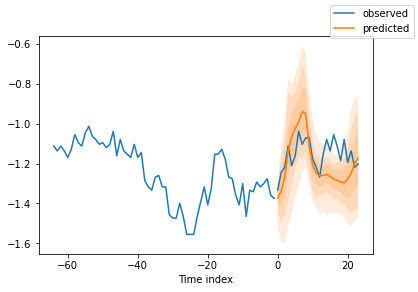

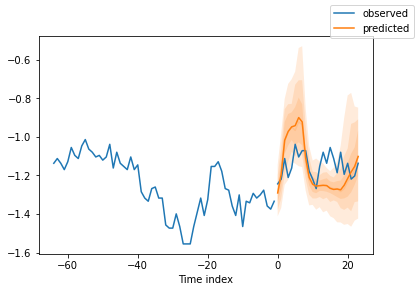

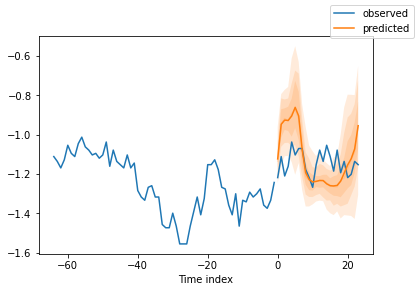

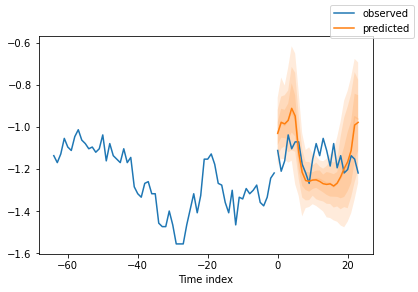

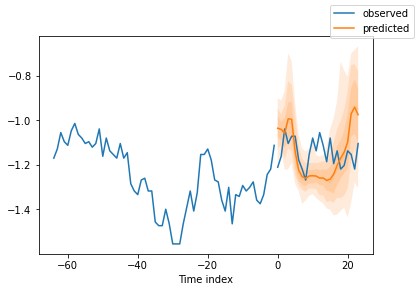

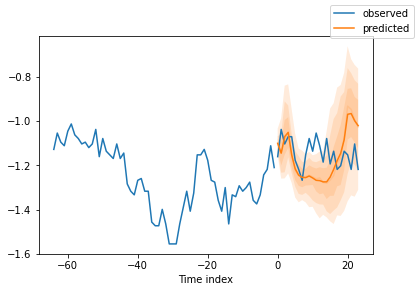

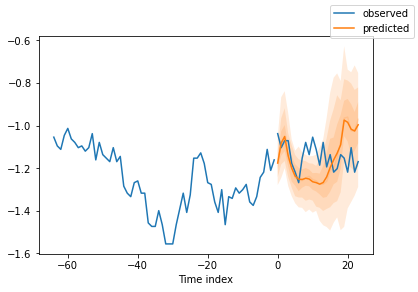

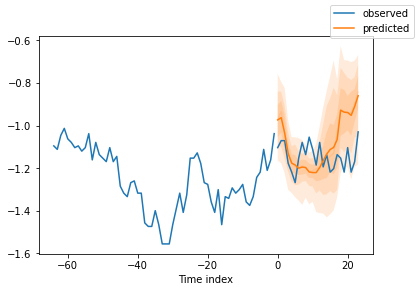

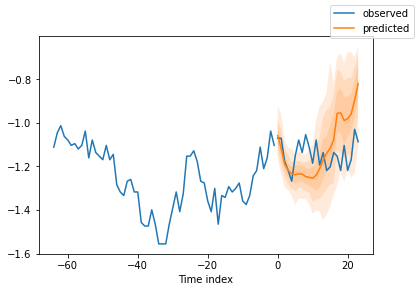

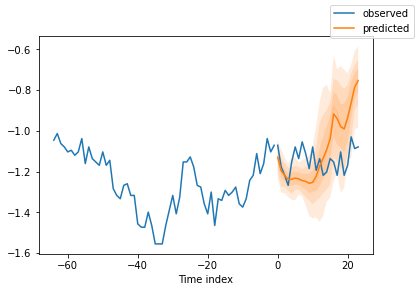

In [116]:
for idx in range(10):
    deepar.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,
                           quantiles_kwargs={'use_metric': False}, prediction_kwargs={'use_metric': False})